# Imputation of peptide abundances
## Data

In this R Notebook, we illustrate how to use scVAEIT on R through peptide abundances data measured by mass spectrometer.
These data are normally distributed (taking both positive and negative values) but missing at random.

In [1]:
load("simulated_peptide.RData")

In [2]:
raw.pep[1:5,1:5]

-0.2697226,NA,NA,-0.5640022,NA
NA,NA,NA,NA,NA
NA,0.1191803,-0.4339813,NA,0.122774
NA,-2.0202053,NA,-0.7947332,NA
1.1508900,NA,NA,-0.7329767,NA


In [3]:
comp.pep[1:5,1:5]

-0.2697226,-0.5043728,-0.5743020,-0.56400219,1.69118295
0.9133593,0.0324714,1.1169943,1.68557128,0.58438257
1.4123398,0.1191803,-0.4339813,0.03837133,0.12277400
1.6874292,-2.0202053,1.5708989,-0.79473315,0.00446075
1.1508900,1.0141109,-0.1465066,-0.73297667,-0.45736804


In [4]:
cat(dim(comp.pep), dim(raw.pep))

1000 500 1000 500

In [5]:
# Randomly generated covariates
n <- nrow(raw.pep)
case <- sample(n,n/2); control=setdiff(c(1:n), case)
label <- rep(0,n); label[case]=1
batches_cate <- matrix(as.factor(label),ncol=1,byrow=F)

ls2 <- log(rowSums((raw.pep!=0) & (!is.na(raw.pep))))
batches_cont <- matrix(c(ls2),ncol=1,byrow=F)

data <- raw.pep; data[is.na(data)] <- 0.; data <- as.matrix(data)
masks <- - as.matrix(is.na(as.matrix(raw.pep)))

## Loading Python Package from R

In [6]:
# import Python package (call after setting up python environment with reticulate)
# Use 'reticulate' to access Python environment
library(reticulate)
use_condaenv(condaenv = "tf")
# If the package is installed via PyPI in the Python environment,
# simply import it:
# scVAEIT <- import("scVAEIT")
# Otherwise, need to downloaded Github repo, set a proper path to import the module.
setwd('../../../../')
scVAEIT <- import("scVAEIT")
scVAEIT$`__version__`

[1] "1.1.0"

## Initialize scVAEIT model

In [7]:
config = list(
# A network stucture of 
# x     :              dim_input -> 64 -> 16 -> z 4 -> 16 -> 64 -> dim_input
#                                 |             |
# masks : dim_input -> dim_embed ->             ->
    'dimensions'=c(16), # hidden layers
    'dim_latent'=4L,    # latent space

    # Block structure for the input and output layer
    'dim_block_enc'=c(64),
    'dim_block_dec'=c(64),
    'dist_block'=list('Gaussian'), # use Gaussian likelihood by default

    'dim_block_embed'=128L,

    # some hyperparameters
    'beta_unobs'=0.5,

    # prob of random maskings
    'p_feat'=0.2,
    'beta_reverse'=0.2,

    # skip connection for improving imputation quality
    'skip_conn'=T
)
scVAEIT$reset_random_seeds(as.integer(0))

cat('Initializing model...\n')
model <- scVAEIT$VAEIT(config, data, masks, NULL, batches_cate, batches_cont)

Initializing model...


In [8]:
model$config

namespace(beta_kl=2.0, beta_unobs=0.5, beta_reverse=0.2, beta_modal=array([1.], dtype=float32), p_modal=None, p_feat=0.2, uni_block_names=array(['M-0'], dtype='<U23'), block_names=array(['M-0'], dtype='<U23'), dist_block=array(['Gaussian'], dtype='<U8'), dim_block=array([500], dtype=int32), dim_block_enc=array([64], dtype=int32), dim_block_dec=array([64], dtype=int32), skip_conn=True, mean_vals=<tf.Tensor: shape=(500,), dtype=float32, numpy=
array([0.44167346, 0.48984244, 0.5465714 , 0.46952555, 0.58617085,
       0.3595247 , 0.5914804 , 0.44657955, 0.46613336, 0.5135204 ,
       0.4015038 , 0.5733716 , 0.60520023, 0.43958527, 0.5650931 ,
       0.5828378 , 0.5444924 , 0.5714362 , 0.3516288 , 0.44687292,
       0.5197562 , 0.49680597, 0.43845636, 0.39757198, 0.4432136 ,
       0.4323344 , 0.4887178 , 0.5314573 , 0.37781012, 0.5152997 ,
       0.363956  , 0.5152584 , 0.4640951 , 0.41251922, 0.4628549 ,
       0.4418806 , 0.4116188 , 0.46998972, 0.524338  , 0.4115528 ,
       0.578989  ,

## Model training and inference

In [9]:
hist <- model$train(num_epoch=2000, verbose=FALSE)

# Save model if needed
# model$save_model('example/result/R/checkpoint/')

# Next time, load model without training again
# model$load_model('example/result/R/checkpoint/')

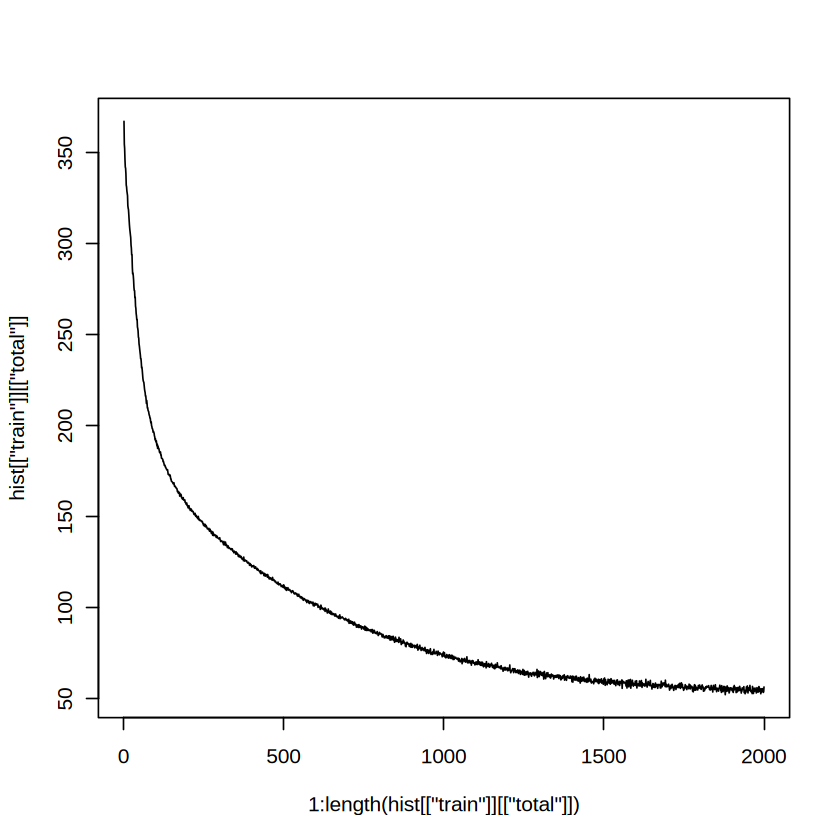

In [10]:
plot(1:length(hist[['train']][['total']]), hist[['train']][['total']], type="l")

After the model is trained, we can get impouted and denoised abundances:

In [11]:
imp.pep <- model$get_denoised_data(return_mean=TRUE)

One can also use pulgin estimate (only the missing values are imputed):

In [12]:
blend.pep <- data
ina <- masks!=0
blend.pep[ina] <- imp.pep[ina]
rownames(blend.pep) <- rownames(data)
colnames(blend.pep) <- colnames(data)

## Visualize

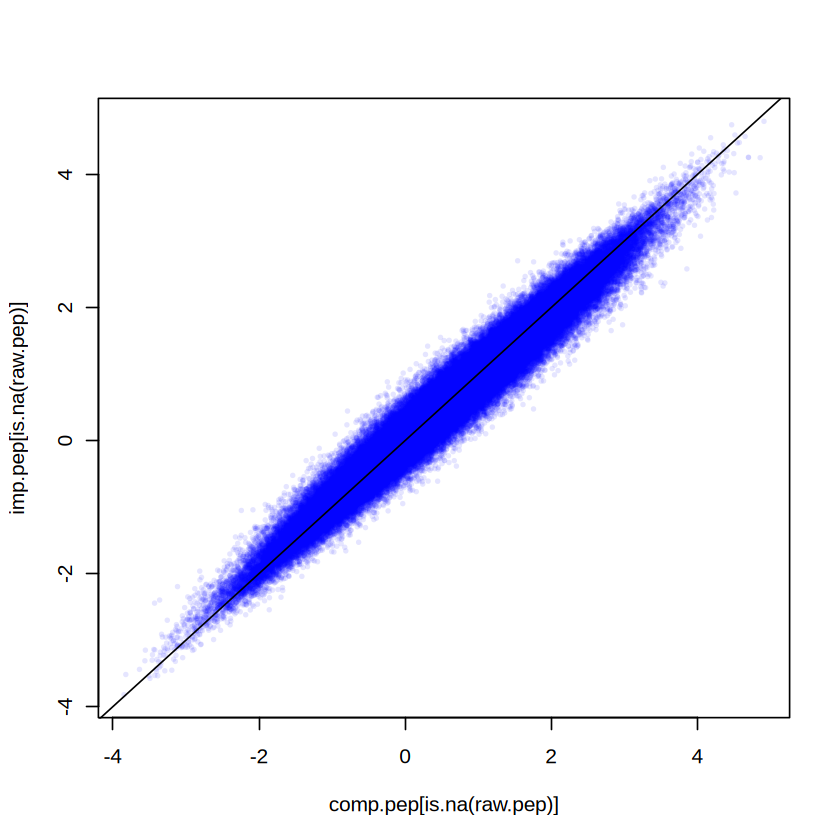

In [13]:
plot(comp.pep[is.na(raw.pep)], imp.pep[is.na(raw.pep)],
     pch = 16, cex = .5, col = rgb(red = 0, green = 0, blue = 1, alpha = 0.1)
)
abline(0,1)

In [14]:
cat(mean(((comp.pep - imp.pep)**2)[is.na(raw.pep)]))

0.04359538

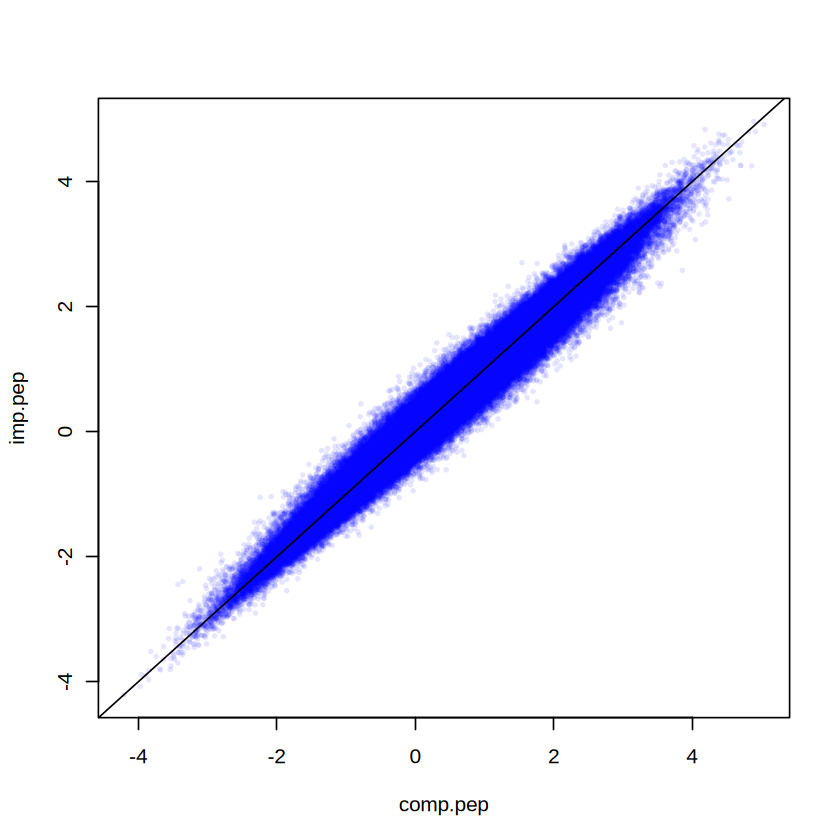

In [15]:
plot(comp.pep, imp.pep,
    pch = 16, cex = .5, col = rgb(red = 0, green = 0, blue = 1, alpha = 0.1)
)
abline(0,1)

## R function interface

When the above procedure works properly, it is convenient to have a simple interface to iteratively the same procedure and to tune over different hyperparameters.
For this purpose, we can create a wrapper function as R file (e.g. `"R_wrapper.R"` in the current directory) and load the wrapper function in any R program by the following commands:

```r
source("R_wrapper.R")
```

When using the above command, ***make sure to use the correct path, or set up the workspace path properly.***